# Session 1
---
本次作業的資料是從中央氣象局網站下載的真實觀測資料，希望大家利用linear regression或其他方法預測PM2.5的數值。

作業使用豐原站的觀測記錄，分成train set跟test set，train set是豐原站每個月的前20天所有資料。test set則是從豐原站剩下的資料中取樣出來。

train.csv：每個月前20天的完整資料。

test_X.csv：從剩下的10天資料中取樣出連續的10小時為一筆，前九小時的所有觀測數據當作feature，第十小時的PM2.5當作answer。一共取出240筆不重複的test data，請根據feauure預測這240筆的PM2.5。

---
## Required Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
import pandas as pd

from task_io import TaskIO


class Session1TaskIO(TaskIO):
    def export_prediction(self, data):
        print('===== Exporting prediction result... =====')
        data.to_csv(self.result, index=False)

---
## Data Observation

First, I extracted the value of pm 2.5 from the imported data.

In [2]:
task_io = Session1TaskIO(
    train='./data/train.csv',
    test='./data/test_X.csv',
    result='./data/result.csv'
)
training_data = task_io.import_training_data()
testing_data = task_io.import_testing_data()

pm_25_dates = training_data[training_data['測項'] == 'PM2.5'].loc[:, '日期']
pm_25 = training_data[training_data['測項'] == 'PM2.5'].loc[:, '0':'23'].apply(pd.to_numeric)
pm_25.describe()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
count,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,...,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,19.137500,18.270833,17.625000,16.737500,16.154167,16.041667,15.766667,16.250000,17.104167,19.087500,...,26.404167,26.779167,27.341667,27.241667,26.341667,25.383333,24.162500,22.883333,21.379167,20.170833
std,15.164711,15.616668,15.423485,15.328818,14.243151,14.008901,13.669582,13.623601,14.195644,15.294482,...,17.955989,17.248285,17.367307,18.313630,18.026710,18.250550,17.779997,17.459425,15.829967,15.221378
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,8.000000,6.750000,7.000000,5.000000,4.750000,6.000000,6.750000,6.000000,7.000000,7.750000,...,13.000000,13.000000,15.000000,14.000000,14.000000,13.000000,13.000000,12.000000,10.000000,9.000000
50%,17.000000,15.000000,14.000000,13.000000,13.000000,13.000000,13.000000,13.000000,14.000000,15.500000,...,23.000000,24.500000,24.000000,23.000000,22.000000,22.000000,20.000000,19.000000,18.000000,17.000000
75%,26.000000,25.000000,24.000000,23.000000,22.250000,22.250000,23.000000,22.000000,24.000000,27.000000,...,35.000000,36.000000,36.250000,37.000000,36.000000,33.250000,32.000000,29.250000,27.250000,28.000000
max,92.000000,97.000000,90.000000,81.000000,75.000000,70.000000,70.000000,72.000000,76.000000,80.000000,...,94.000000,90.000000,109.000000,109.000000,105.000000,102.000000,106.000000,112.000000,92.000000,82.000000


---
Now, I'm trying to see the pattern from the daily change of pm 2.5, but the chart seems not helping at all. Perhaps the season has nothing to do with pm 2.5.

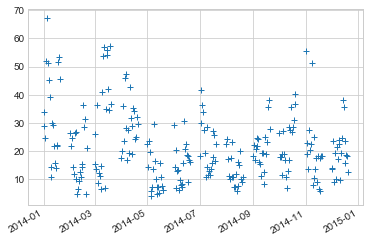

In [3]:
import matplotlib.dates as mdates
from datetime import datetime

dates = [datetime.strptime(date, '%Y/%m/%d') for date in pm_25_dates.values]
daily_pm_25 = pm_25.mean(axis=1)

fig, ax = plt.subplots()
ax.plot_date(dates, daily_pm_25, '+')
fig.autofmt_xdate()

plt.show()

---
After ploting the change of the averaged values of pm 2.5 hourly, the pattern appears to be aligned with a *sin* function.

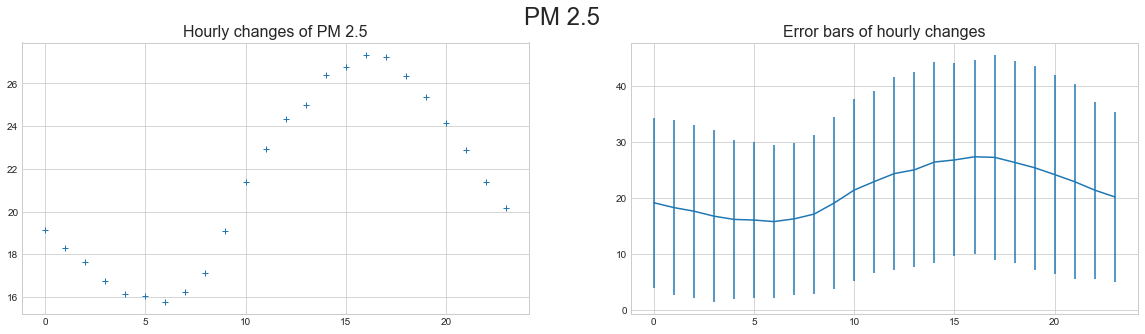

In [4]:
y = pm_25.describe().loc['mean', :]
x = y.index.astype('float64').to_series()
error = pm_25.describe().loc['std', :]

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20, 5))
fig.suptitle('PM 2.5', fontsize=24)

ax0.plot(y, '+')
ax0.set_title(
    'Hourly changes of PM 2.5',
    {'fontsize': 16}
)

ax1.errorbar(x, y, yerr=error)
ax1.set_title(
    'Error bars of hourly changes',
    {'fontsize': 16}
)

plt.show()

---
Now, let's take a look at all the features we can get from the data.

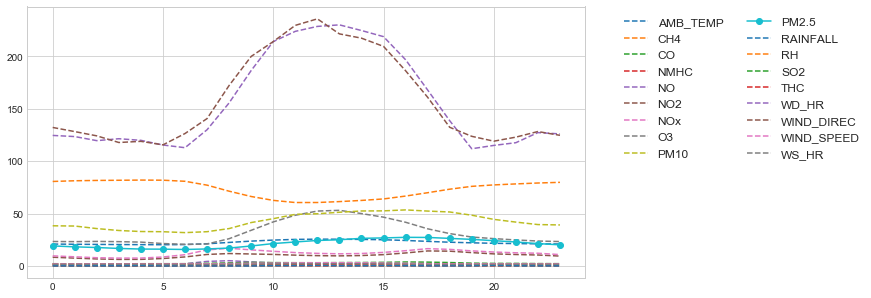

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))

features = training_data.groupby('測項')
for (feature, group) in features:
    values = group.loc[:, '0':'23']
    if feature == 'RAINFALL':
        values = values.replace('NR', '0')
    means = values.apply(pd.to_numeric).describe().loc['mean', :]
    ax.plot(means, '-o' if feature == 'PM2.5' else '--', label=feature)

from matplotlib.font_manager import FontProperties

fontP = FontProperties()
fontP.set_size('large')
ax.legend(
    loc=2,
    ncol=2,
    prop = fontP,
    bbox_to_anchor=(1.05, 1)
)
plt.show()

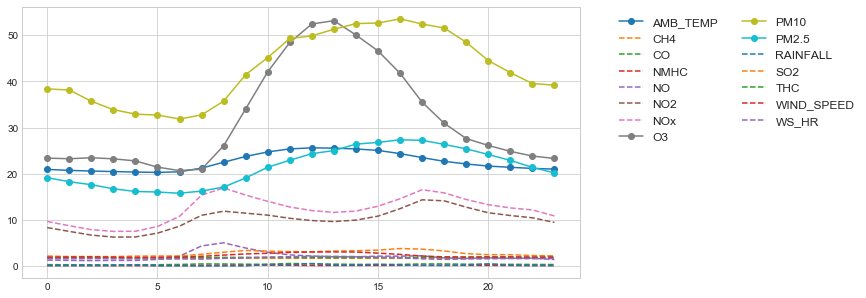

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))

features = training_data.groupby('測項')
for (feature, group) in features:
    outliers = ['WIND_DIREC', 'WD_HR', 'RH']
    correlated = ['PM2.5', 'AMB_TEMP', 'O3', 'PM10']
    if feature in outliers:
        continue
    values = group.loc[:, '0':'23']
    if feature == 'RAINFALL':
        values = values.replace('NR', '0')
    means = values.apply(pd.to_numeric).describe().loc['mean', :]
    ax.plot(means, '-o' if feature in correlated else '--', label=feature)

from matplotlib.font_manager import FontProperties

fontP = FontProperties()
fontP.set_size('large')
ax.legend(
    loc=2,
    ncol=2,
    prop = fontP,
    bbox_to_anchor=(1.05, 1)
)
plt.show()

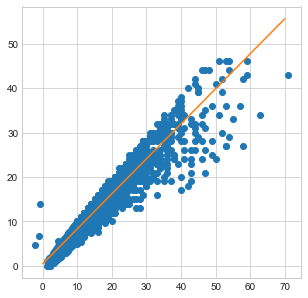

In [10]:
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

x = pd.Series()
y = pd.Series()

feature = training_data[training_data['測項'] == 'NOx'].loc[:, '0':'23'].apply(pd.to_numeric)
outcome = training_data[training_data['測項'] == 'NO2'].loc[:, '0':'23'].apply(pd.to_numeric)
for hour in feature:
    x = x.append(feature[hour].map(lambda elem: elem), ignore_index=True)

for hour in outcome:
    y = y.append(outcome[hour].map(lambda elem: elem), ignore_index=True)

from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 70, 1000)
yfit = model.predict(xfit[:, np.newaxis])

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(x, y, 'o')
ax.plot(xfit, yfit)
plt.show()

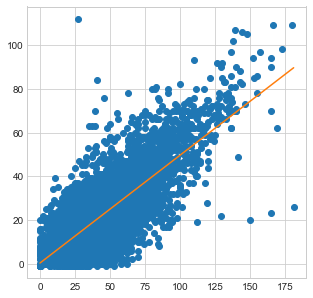

In [15]:
x = pd.Series()
y = pd.Series()

feature = training_data[training_data['測項'] == 'PM10'].loc[:, '0':'23'].apply(pd.to_numeric)
outcome = pm_25
for hour in feature:
    x = x.append(feature[hour].map(lambda elem: elem), ignore_index=True)
    y = y.append(outcome[hour].map(lambda elem: elem), ignore_index=True)

from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, feature.max().max(), 1000)
yfit = model.predict(xfit[:, np.newaxis])

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(x, y, 'o')
ax.plot(xfit, yfit)
plt.show()